# Project Idea
* The idea of the project is to keep the robot from the wall with static distance to replace PID method.
* <a href=https://en.wikipedia.org/wiki/PID_controller>Proportional–Integral–Derivative controller</a> is one of the method used for it but it need manual modification to get the constant variables.
* Here we let the machine learn by it self and decide the required speed depending on the position.
* (The algorithm Control specific region around the optimal distance only) other wise it might stuck far away from the wanted distance trying random actions.

# Robot behavior Simulater

<b>The simulator created to minimze battery consumption on the real robot, used for testing and preparing code</b>

In [37]:
import numpy as np
from time import sleep
import sys
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(1377)

# Due to Battery Limitation This is A Robot Simulator
* We interact with the robot using fwd,bwd,speed only
* the robot feed back is it's distance from the wall

In [2]:
class Robot:
    def __init__(self,ActionDuration =0.01):
        self.actionduration = ActionDuration
        self.distance = np.random.randint(0,100)
        
    def RegulaizeSpeed(self,speed):
        if speed>255:
            return 255
        if speed<-255:
            return -255
        return speed
    
    def Move(self,speed):
        if speed ==0:
            self.StandStill()
        elif speed<0:
            self.bwd(speed)
        elif speed>0:
            self.fwd(speed)

    def fwd(self,speed):
        d = self.RegulaizeSpeed(speed) * self.actionduration
        self.distance-= d
        if self.distance<0:
            self.distance=0
        return self.distance
    
    def bwd(self,speed):
        
        d = -1*self.RegulaizeSpeed(speed) * self.actionduration
        self.distance+= d
        return self.distance
    
    def StandStill(self):
        sleep(self.actionduration)
        return self.distance

In [52]:
def Draw(main,text):
    lst=[]
    for i in range(main.qsa.shape[0]):
        lst.append((main.States[i,0],main.actions[np.argmax(main.qsa[i])]))
    lst=lst[1:len(lst)-1]
    allinfo = np.array(lst)
    plt.plot(allinfo[:,0],allinfo[:,1])
    plt.title(text)
    plt.show()

# Reinforcement Learning Model

In [45]:
class RL_Controller:
    
    def __init__(self,lmbda=0.1,optimal_distance=30,staticActionThreshould=1,actionscount=3,StatesCount=5,\
                 Exploration=0.1,loaddata=False):
        '''
        staticActionThreshould : when distance more or less than 3*std Robot will get static action
        ActionsCount : 1 for no action , rest divided by 2 to cover positive , negative
        StatesCount : at least 4 per Side
        '''
        self.lmbda =lmbda
        self.Exploration = Exploration
        self.ActionsCount=actionscount
        self.StatesCount= StatesCount
        self.actions= 0
        self.States=0
        self.std = np.round(np.std(np.arange(0,optimal_distance*2)))*staticActionThreshould
        self.AcceptedError = np.array((-1.0,1.0))*(0.03*optimal_distance)
        self.qsa=0
        self.OptimalDistance =30
        np.random.seed(1377)
        self.Robot = Robot()
        #====Sarsa Related ===#
        self.qsa=0
        self.n=0
        self.et=0
        self.Terminated=False
        
        #self.stats = 
    def GenerateActions(self):
        if self.ActionsCount%2==0:
            self.ActionsCount+=1
        if self.ActionsCount<3:
            self.ActionsCount=3
        lst =[]
        #fwd or bwd number of actions
        for i in range ((self.ActionsCount-1)/2 +1):
            if i==0:
                lst.append(i)
                continue
            lst = [-i]+lst
            lst.append(i)
        self.actions= (np.array(lst)/(max(lst)*1.0))*255
        
    def GenerateStats(self):
        lst=[]
        if (self.StatesCount-1)%2==0:
            self.StatesCount+=1
        if self.StatesCount<4:
            self.StatesCount=4
        for i in range(self.StatesCount):
            if i==0:
                lst.append(i)
                continue
            lst = [-i]+lst
            lst.append(i)
        lst = (np.array(lst)/(np.max(lst)*1.0))*self.std
        lstdomains=[]
        for i in range(len(lst)-1):
            lstdomains.append((lst[i],lst[i+1]))
        lstdomains = [(-3000,lst[0])] + lstdomains
        lstdomains.append((lst[len(lst)-1],3000))
        self.States = np.array(lstdomains)
        self.StatesCount = self.States.shape[0]
    
    def PrepareForSarsa(self):
        self.qsa =np.random.uniform(-1,1,size=(self.States.shape[0],self.actions.shape[0]))
        self.et = np.zeros((self.States.shape[0],self.actions.shape[0]))
        self.n = np.zeros(self.States.shape[0])
        
    def Initalization(self):
        print '=====Initialization====='
        self.GenerateActions()
        self.GenerateStats()
        self.PrepareForSarsa()
        print """Lambda={},Exploration={},OptimalDistance={},Actions={},States={},Std={},Accepted Error={},
        Robot Distance={},Qsa={}""".\
        format(self.lmbda,self.Exploration,self.OptimalDistance,self.actions.shape,self.States.shape,self.std,\
               self.AcceptedError,self.Robot.distance,self.qsa.shape)
        
    def GetStateIndex(self,CurrentState):
        for i in range (self.States.shape[0]):
            if self.States[i,0]<=CurrentState<=self.States[i,1]:
                return i
    
    def GetAction(self,statindx):
        
        #Deterministic solution for state out of range to assure the Robot won't get lost
        if statindx==0:
            #print 'distance:{},statindx:{},state:{},action:{}'.format(self.Robot.distance, statindx,self.States[statindx],self.actions[len(self.actions)-1])
            return 0
        if statindx==len(self.States)-1:
            #print 'distance:{},statindx:{},state:{},action:{}'.format(self.Robot.distance,statindx,self.States[statindx],self.actions[0])
            return len(self.actions)-1
        #Exploration Precentage depend on how many specific state  visited
        exploration = 100.0 / (100.0 + self.n[statindx])
        rnd = np.random.rand()
        if rnd < exploration:
            rnd = np.random.randint(len(self.actions))
            return rnd
        else:
            return np.argmax(self.qsa[statindx])
        
    def Step(self,actnindx):
        self.Robot.Move(self.actions[actnindx])
        crntstat = self.GetCurrentState()
        return crntstat,self.GetReward(crntstat)
    
    def GetCurrentState(self):
        return self.Robot.distance - self.OptimalDistance
    
    def GetReward(self,crntstat):
        if self.AcceptedError[0]<=crntstat<=self.AcceptedError[1]:
            self.Terminated=True
            return 10000;
        else:
            return crntstat if crntstat<0 else -1*crntstat
    def UpdateQsa(self,s_indx,s_pindx,a_indx,a_pindx,R):
        self.n[s_indx] += 1
        if self.Terminated:
            qnext =0
        else:
            qnext = self.qsa[s_pindx,a_pindx]

        delta = R + qnext - self.qsa[s_indx,a_indx]
        self.et[s_indx,a_indx] += 1
        try:
            alpha = 1.0 / self.n[s_indx]
        except:
            alpha = 0

        self.qsa += alpha * delta * self.et
        self.et *= self.lmbda
        
    def PlaySarasa(self,nepisode):
        self.n.fill(0)
        for i in range(nepisode):
            self.et.fill(0)
            self.Robot=Robot()
            #print self.Robot.distance
            self.Terminated=False
            #---Game Started -----#
            s = self.GetCurrentState()
            sindx = self.GetStateIndex(s)
            aindx = self.GetAction(sindx)
            iit=0
            while not self.Terminated:
                iit+=1
                s_p, R = self.Step(aindx)
                s_pindx = self.GetStateIndex(s)
                a_pindx = self.GetAction(s_pindx)
                #if i==3 :
                #    print 'dist={},new State = {},s_pindx={},Reward {},new Action = {}'\
                #    .format(self.Robot.distance, s_p,s_pindx,R,self.actions[a_pindx])
                #    if iit==100:
                #        self.Terminated=True
                self.UpdateQsa(sindx,s_pindx,aindx,a_pindx,R)
                s = s_p
                sindx = s_pindx
                aindx = a_pindx
                #action= GetPlayerAction(Easy21)
                #Update Qsa
                #Update(oldp-1,oldd-1,olda,Easy21.Reward,Easy21.playersum-1,action,Easy21.terminated)
                #if Easy21.terminated:
                #    break
                #if i%10000==0:
                #    print i
            if i%100==0:
                clear_output()
                print 'Episode :{}'.format(i)
                
        self.SaveModel(nepisode)
    
    def SaveModel(self,episods,name='qsa'):
        fname = '{},stc:{},ac:{},epi:{}.dat'.format(name,self.States.shape[0],self.actions.shape[0],episods)
        self.qsa.dump(fname)
        
    def LoadModel(self,episods,name='qsa'):
        fname = '{},stc:{},ac:{},epi:{}.dat'.format(name,self.States.shape[0],self.actions.shape[0],episods)
        self.qsa = np.load(fname)       
            

=====Initialization=====
Lambda=0.1,Exploration=0.1,OptimalDistance=30,Actions=(11,),States=(200, 2),Std=17.0,Accepted Error=[-0.9  0.9],
        Robot Distance=54,Qsa=(200, 11)


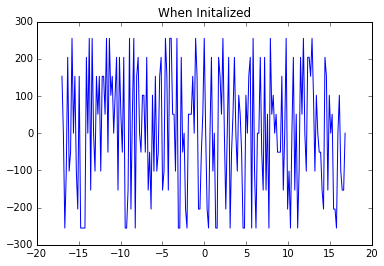

In [59]:
main = RL_Controller(optimal_distance=30,actionscount=10,StatesCount=100)
main.Initalization()
Draw(main,'When Initalized')

In [58]:
main.PlaySarasa(1000)

Episode :900


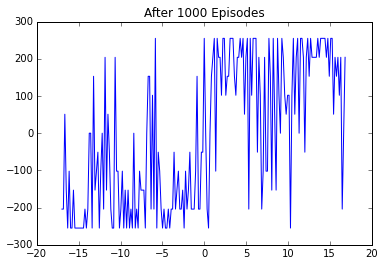

In [55]:
Draw(main,'After 1000 Episodes')

In [ ]:
main.PlaySarasa(24300)

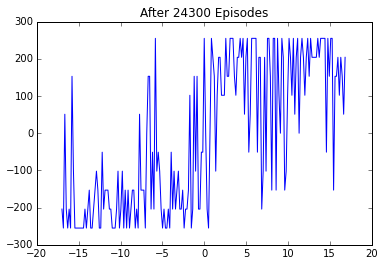

In [61]:
Draw(main,'After 24300 Episodes')

In [56]:
for i in range (main.States.shape[0]):
    print 'Domain:{},Best Action:{},Happend:{}'.\
    format(main.States[i],main.actions[np.argmax(main.qsa[i])],main.n[i])

Domain:[-3000.   -17.],Best Action:0.0,Happend:680.0
Domain:[-17.         -16.82828283],Best Action:-204.0,Happend:28.0
Domain:[-16.82828283 -16.65656566],Best Action:-204.0,Happend:20.0
Domain:[-16.65656566 -16.48484848],Best Action:51.0,Happend:21.0
Domain:[-16.48484848 -16.31313131],Best Action:-153.0,Happend:43.0
Domain:[-16.31313131 -16.14141414],Best Action:-255.0,Happend:26.0
Domain:[-16.14141414 -15.96969697],Best Action:-102.0,Happend:38.0
Domain:[-15.96969697 -15.7979798 ],Best Action:-255.0,Happend:54.0
Domain:[-15.7979798  -15.62626263],Best Action:-255.0,Happend:16.0
Domain:[-15.62626263 -15.45454545],Best Action:-153.0,Happend:34.0
Domain:[-15.45454545 -15.28282828],Best Action:-255.0,Happend:51.0
Domain:[-15.28282828 -15.11111111],Best Action:-255.0,Happend:37.0
Domain:[-15.11111111 -14.93939394],Best Action:-255.0,Happend:78.0
Domain:[-14.93939394 -14.76767677],Best Action:-255.0,Happend:62.0
Domain:[-14.76767677 -14.5959596 ],Best Action:-255.0,Happend:49.0
Domain:[-14

In [ ]:
print main.Robot.distance
main.Robot.bwd(10)
print main.Robot.distance

In [34]:
main.qsa

array([[ -4.86079598e+01,  -3.69799322e-01,  -7.99636621e-01, ...,
         -9.06011797e-01,  -5.34107766e-01,  -9.95338563e-01],
       [ -1.66335484e+01,  -7.04149432e+00,  -6.01316346e+00, ...,
         -7.61609585e+00,  -7.79820359e+00,  -1.13335387e+01],
       [ -3.64008250e+00,  -4.05207040e+00,  -1.12008732e+01, ...,
         -5.08551684e+00,  -1.29540513e+01,  -2.27656415e+01],
       ..., 
       [ -8.92406157e+00,  -1.03510871e+01,  -1.03781501e+01, ...,
         -1.26936161e+01,  -1.81213799e+01,  -2.49143705e+01],
       [ -1.07948236e+01,  -9.18114805e+01,  -1.11387349e+01, ...,
         -1.08170697e+01,  -1.64289041e+01,  -2.22118341e+01],
       [ -3.29301547e-02,   7.16686700e-01,  -4.72632422e-01, ...,
         -2.87673928e-01,   2.48335256e-01,  -1.55202599e+02]])

# Problems 
* The Accepted error is 3% so if the optimal distance is 1000 that's mean 970 - 1030 considered as accepted areas.

* Training Should be in Optimal area, but testing can be in any area.